In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate
import tensorflow as tf
import tensorflow.keras

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json, Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator,  array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical

PARENT_DATA_DIR ='/content/drive/MyDrive/DFU Dataset/DFUC-2020'
TRAIN_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'Train Set')
VALID_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'Test Set')

['Foot Ulcer', 'Normal']


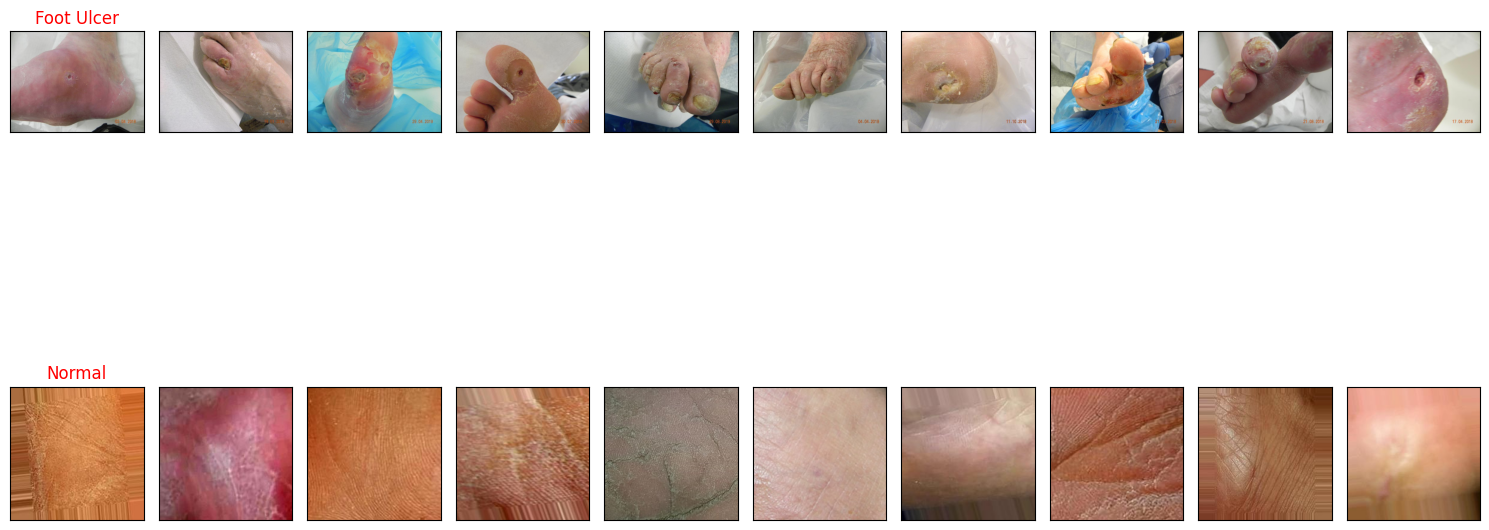

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

IMG_SIZE = 96
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
print(CATEGORIES)

classes = len(CATEGORIES)

plt.figure(figsize=(15, 10), facecolor='white')
i = 1
num_images_per_class = 10

def resize_image(img):
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

def rotate_image(img, angle=15):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    return cv2.warpAffine(img, M, (w, h))

def zoom_image(img, zoom_factor=1.15):
    h, w = img.shape[:2]
    new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
    resized = cv2.resize(img, (new_w, new_h))
    startx = new_w // 2 - w // 2
    starty = new_h // 2 - h // 2
    return resized[starty:starty+h, startx:startx+w]

def add_gaussian_noise(img, mean=0, var=0.01):
    sigma = var**0.5
    noise = np.random.normal(mean, sigma, img.shape)
    noisy = img / 255.0 + noise
    noisy = np.clip(noisy, 0, 1)
    return (noisy * 255).astype(np.uint8)

def adjust_brightness(img, factor=1.1):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[..., 2] = hsv[..., 2] * factor
    hsv[..., 2][hsv[..., 2] > 255] = 255
    hsv = np.array(hsv, dtype=np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    image_list = os.listdir(path)
    if len(image_list) < num_images_per_class:
        continue
    random.shuffle(image_list)
    image_list = image_list[:num_images_per_class]

    for img_name in image_list:
        img_array = cv2.imread(os.path.join(path, img_name))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

        # Apply data preprocessing
        img_array = resize_image(img_array)                       # 1. Resize to 96x96
        img_array = rotate_image(img_array, angle=15)            # 2. Rotate 15 degrees
        img_array = zoom_image(img_array, zoom_factor=1.15)      # 3. Zoom
        img_array = add_gaussian_noise(img_array, 0, 0.01)       # 4. Add Gaussian noise
        img_array = adjust_brightness(img_array, factor=1.1)     # 5. Brightness standardization

        white_background = 255 * np.ones((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        x_offset = (white_background.shape[1] - img_array.shape[1]) // 2
        y_offset = (white_background.shape[0] - img_array.shape[0]) // 2
        white_background[y_offset:y_offset + img_array.shape[0], x_offset:x_offset + img_array.shape[1]] = img_array

        plt.subplot(len(CATEGORIES), num_images_per_class, i)
        plt.imshow(white_background)

        if i % num_images_per_class == 1:
            plt.title(c, color='red')

        plt.xticks([])
        plt.yticks([])
        i += 1

plt.tight_layout()
plt.show()


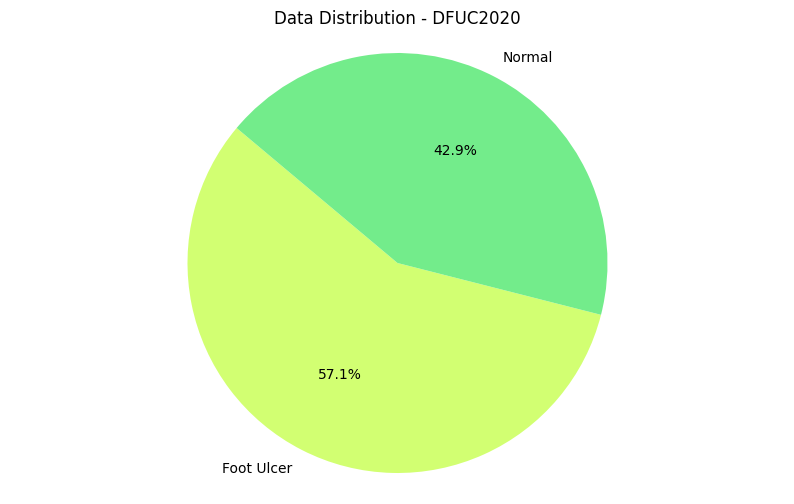

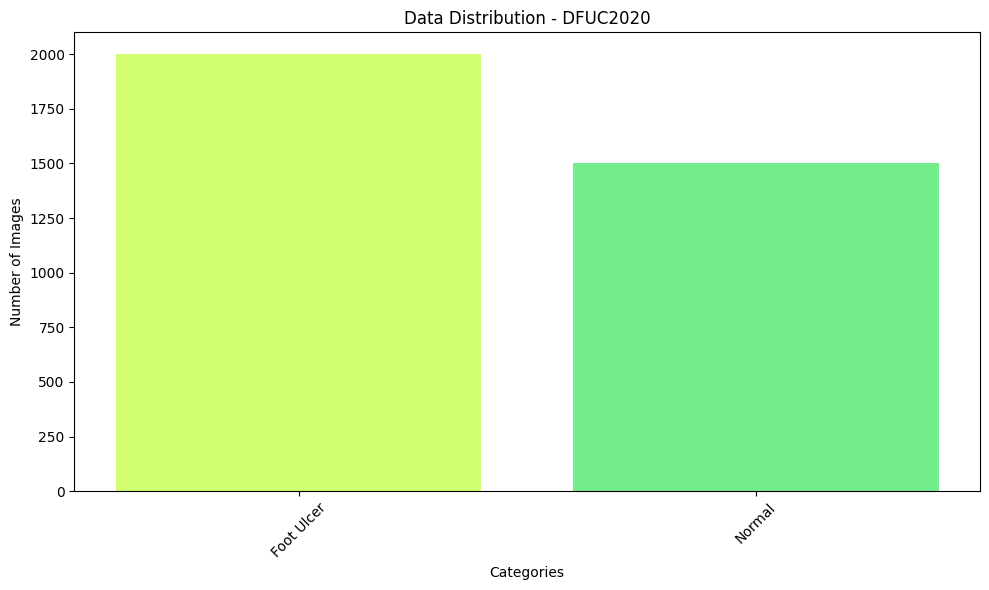

In [ ]:
category_counts = {}
for category in CATEGORIES:
    category_path = os.path.join(TRAIN_DATA_DIR, category)
    num_images = len(os.listdir(category_path))
    category_counts[category] = num_images


# Define custom colors
custom_colors = ['#D2FF72','#73EC8B','#99ff99']

# Plot pie chart
plt.figure(figsize=(10, 6), facecolor='white')
plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%', startangle=140, colors=custom_colors)
plt.title('Data Distribution - DFUC2020')
plt.axis('equal')
plt.show()

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values(), color=custom_colors)
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Data Distribution - DFUC2020')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(training_data))

test_data = []

for c in CATEGORIES:
    path = os.path.join(VALID_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(test_data))

X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")
X_train, X_test = X_train / 255.0, X_test / 255.0

100%|██████████| 1500/1500 [00:31<00:00, 46.99it/s] 


3500


100%|██████████| 843/843 [00:21<00:00, 39.13it/s] 


2843
X_train= (3500, 96, 96, 3) Y_train= (3500,)
X_test= (2843, 96, 96, 3) Y_test= (2843,)


In [ ]:
pip install -q efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00


In [ ]:
import efficientnet.tfkeras as efn
from tensorflow.keras.callbacks import ModelCheckpoint

# Define callback to save best model
checkpoint_cb = ModelCheckpoint(
    'best_model_efficientnetb0.h5',        # File path to save the model
    monitor='val_accuracy',                # Metric to monitor
    save_best_only=True,                   # Only save model if it's the best so far
    mode='max',                            # Maximize validation accuracy
    verbose=1                              # Print message when saving
)

enet = efn.EfficientNetB0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet',
    include_top=False
)

for layer in enet.layers:
    layer.trainable = False

# Build the model
x = enet.output
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
y = tf.keras.layers.Dense(classes, activation='softmax')(x)

e_model_b0 = tf.keras.Model(inputs=enet.input, outputs=y)

# Compile the model
e_model_b0.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
e_model_b0.summary()

# Train the model with checkpoint callback
efficientnet_b0 = e_model_b0.fit(
    x=X_train,
    y=Y_train,
    epochs=200,
    validation_data=(X_test, Y_test),
    batch_size=64,
    callbacks=[checkpoint_cb]
)


16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 96, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 48, 48, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 48, 48, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 48, 48, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 48, 48, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 48, 48, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 48, 48, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 32)       │            288 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_excite         │ (None, 48, 48, 32)     │              0 │ block1a_activation[0]… │
│ (Multiply)                │                        │                │ block1a_se_expand[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 48, 48, 16)     │            512 │ block1a_se_excite[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 48, 48, 16)     │             64 │ block1a_project_conv[… │
│ (BatchNormalization) 

 Total params: 4,379,038 (16.70 MB)

 Trainable params: 328,962 (1.25 MB)

 Non-trainable params: 4,050,076 (15.45 MB)

Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 75s 657ms/step - accuracy: 0.9102 - loss: 0.2264 - val_accuracy: 0.9905 - val_loss: 0.0361
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.9918 - loss: 0.0290 - val_accuracy: 0.9884 - val_loss: 0.0408
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9938 - loss: 0.0172 - val_accuracy: 0.9894 - val_loss: 0.0438
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9980 - loss: 0.0089 - val_accuracy: 0.9926 - val_loss: 0.0336
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9976 - loss: 0.0067 - val_accuracy: 0.9926 - val_loss: 0.0353
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9981 - loss: 0.0049 - val_accuracy: 0.9930 - val_loss: 0.0297
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9984 - loss: 0.0037 - val_accuracy: 0.9930 - val_loss: 0.0312
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9973 - loss: 0.0045 - val_accuracy:

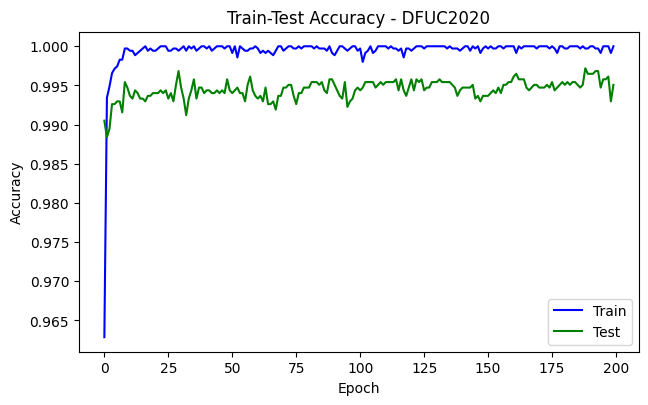

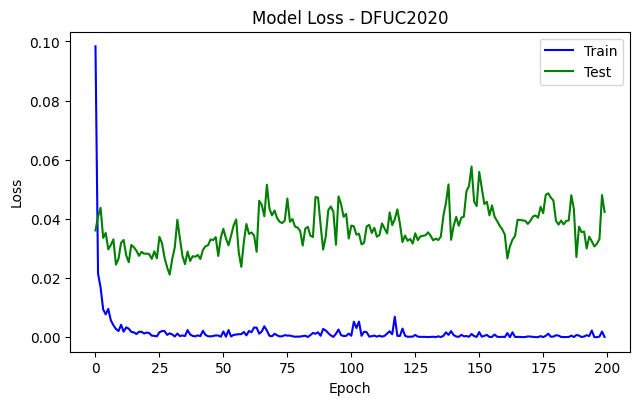

In [ ]:
import seaborn as sns
#  "Accuracy"
plt.figure(figsize=[7, 4])
plt.plot(efficientnet_b0.history['accuracy'], color="blue")
plt.plot(efficientnet_b0.history['val_accuracy'] , color="green")
plt.title('Train-Test Accuracy - DFUC2020')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

# "Loss"
plt.figure(figsize=[7, 4])
plt.plot(efficientnet_b0.history['loss'], color="blue")
plt.plot(efficientnet_b0.history['val_loss'], color="green")
plt.title('Model Loss - DFUC2020')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
from sklearn.svm import SVC

features_train = e_model_b0.predict(X_train)
features_test = e_model_b0.predict(X_test)
features_train_flat = features_train.reshape(features_train.shape[0], -1)
features_test_flat = features_test.reshape(features_test.shape[0], -1)
svm = SVC(kernel='rbf', C=1.0, gamma='auto')
svm.fit(features_train_flat, Y_train)

110/110 ━━━━━━━━━━━━━━━━━━━━ 34s 175ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step


SVC(gamma='auto')

In [ ]:
from sklearn.metrics import hinge_loss

train_accuracy = svm.score(features_train_flat, Y_train)
print(f"Train Accuracy: {train_accuracy}")

test_accuracy = svm.score(features_test_flat, Y_test)
print(f"Test Accuracy: {test_accuracy}")


if Y_train.ndim == 2:
    Y_train_integer = np.argmax(Y_train, axis=1)
else:
    Y_train_integer = Y_train

if Y_test.ndim == 2:
    Y_test_integer = np.argmax(Y_test, axis=1)
else:
    Y_test_integer = Y_test

train_loss = hinge_loss(Y_train_integer, svm.decision_function(features_train_flat))
print(f"Train Loss: {train_loss}")

test_loss = hinge_loss(Y_test_integer, svm.decision_function(features_test_flat))
print(f"Test Loss: {test_loss}")

Train Accuracy: 1.0
Test Accuracy: 0.9954273654590221
Train Loss: 1.475778499112782e-08
Test Loss: 0.009225333559031722


In [ ]:
from sklearn.metrics import classification_report
testX_arg = np.argmax(Y_test)
y_pred = svm.predict(features_test_flat)
print(classification_report(Y_test, y_pred,  digits=7,target_names = CATEGORIES))

              precision    recall  f1-score   support

  Foot Ulcer  1.0000000 0.9935000 0.9967394      2000
      Normal  0.9848131 1.0000000 0.9923484       843

    accuracy                      0.9954274      2843
   macro avg  0.9924065 0.9967500 0.9945439      2843
weighted avg  0.9954968 0.9954274 0.9954374      2843



<Axes: title={'center': 'Confusion Matrix'}>

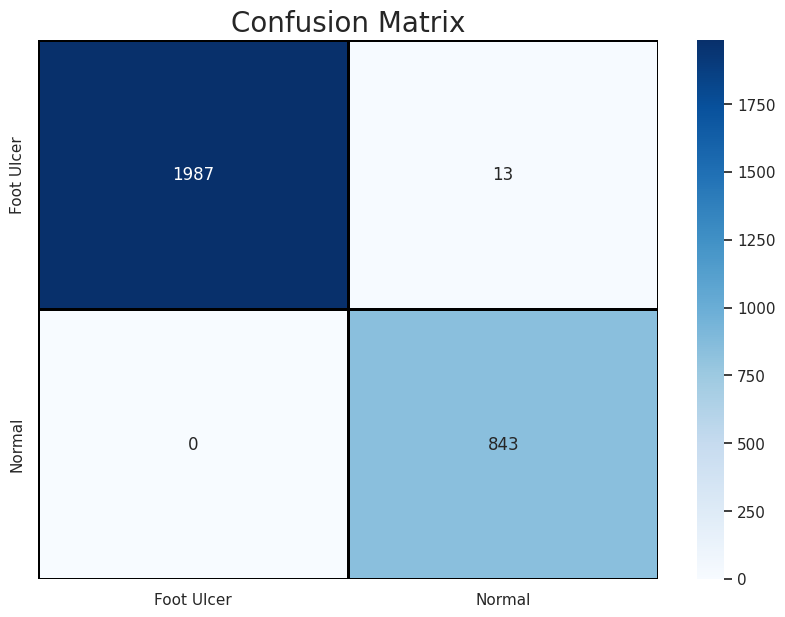

In [ ]:
import pandas as pd
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm
cm = pd.DataFrame(cm , index = CATEGORIES , columns = CATEGORIES)

plt.figure(figsize = (10,7))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

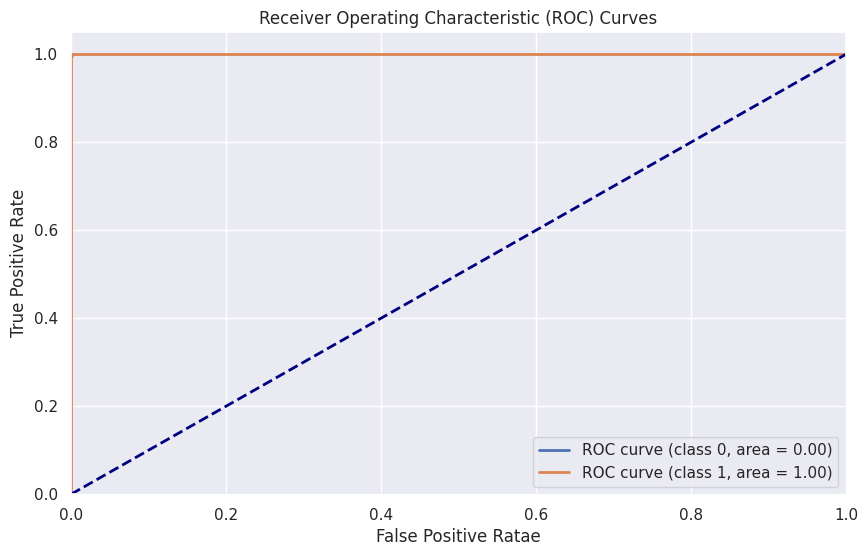

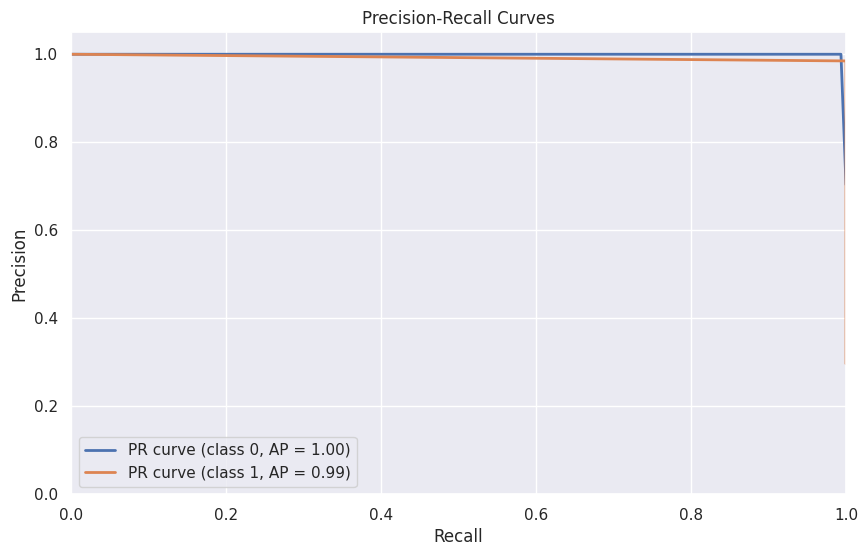

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

svm_output_probs = svm.decision_function(features_test_flat)
svm_output = svm.predict(features_test_flat)
n_classes = len(CATEGORIES)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, svm_output_probs)
    roc_auc[i] = auc(fpr[i], tpr[i])

    precision[i], recall[i], _ = precision_recall_curve(Y_test == i, svm_output == i)
    average_precision[i] = auc(recall[i], precision[i])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (class {i}, area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Ratae')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

# Plot PR curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'PR curve (class {i}, AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.show()
